In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [18]:
import sys
import os

# modify the path below accordingly
PATH = "/content/drive/MyDrive/compvision/gesture_face_features"

sys.path.append(os.path.join(PATH, "code"))

In [19]:
# !pip install mediapipe

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# importing .py files from /code
from utils import *
from config import Config, available_models, available_letters
from heatmap import Heatmap
from tsne import *
# from hand_extraction import extract_hand_mp

In [22]:
print(available_models)
print(available_letters)

['VGG19', 'ResNet50', 'InceptionV3', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB6', 'squeezenet']
['A', 'H', 'L', 'N', 'O', 'P', 'R']


In [54]:
# Configurations
img_type="sign"  # it loads both sign and face in any case (fix the function)
letter = available_letters[0]
is_random = False
load_data = True
img_numbers = [2919, 2871, 2325, 2287, 1646, 1539]
model_name = available_models[0]

In [55]:
print(f"Configuring {model_name} for {img_type} images for letter {letter}")
conf = Config(PATH,
                img_type=img_type,
                letter=letter,
                model_name=model_name,
                load_data=load_data,
                is_random=is_random,
                img_numbers=img_numbers,
              )

Configuring VGG19 for sign images for letter A
No images found for the numbers provided in folder A.
Loading data...
Data loaded successfully.
Setting up model VGG19...
574710816/574710816 [==============================] - 8s 0us/step
Model was set up successfully.


VGG19
1/1 [==============================] - 1s 1s/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Shape: (1, 224, 224, 3)
Last Conv Output Shape: (1, 14, 14, 512)
Squeezed Last Conv Output Shape: (14, 14, 512)
Predicted Class: 841
Upsampled Last Conv Output Shape: (224, 224, 512)
Last Layer Weights for Predicted Class Shape: (4096,)
Reshaped Array (50176, 512)
VGG19 depth averaged or maxed: (50176, 4096)
Final Heat Map Shape: (224, 224)
1/1 [==============================] - 1s 724ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Image Shape: (1, 224, 224, 3)
Last Conv Output Shape: (1, 14, 14, 512)
Squeezed Last Conv Output Shape: (14, 14, 512)
Predicted Class: 834
Upsampled Last Conv Output Shape: (224, 224, 512)
Last Layer Weights for Predicted Class Shape: (4096,)
Reshaped Array (50176, 512)
VGG19 depth averaged or maxed: (50176, 4096)
Final Heat Map Shape: (224, 224)
1/1 [==============================] - 1s 713ms/step
Input Image Shape: (224, 224, 3)
Preprocessed Im

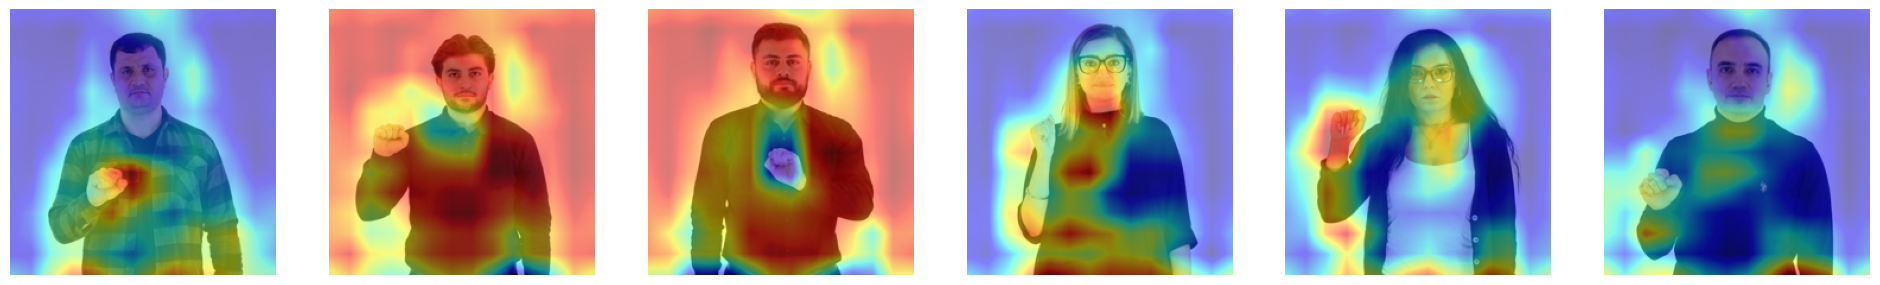

In [56]:
hm = Heatmap(*conf.heatmap_config)
hm.generate_heatmaps_row(imgs_per_row=6)

In [ ]:
last_conv_outputs = conf.get_last_conv_outputs(conf.img_type)
tsne_embedding = get_tsne(last_conv_outputs, plot=False)

1/1 [==============================] - 0s 207ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


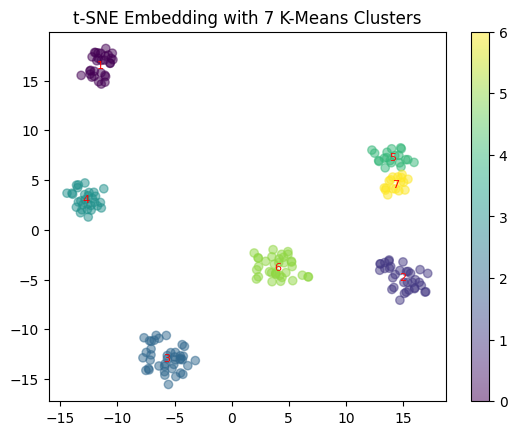

In [ ]:
# num_clusters sould be equal to the number letters
clusters = cluster(tsne_embedding, num_clusters=len(letter))

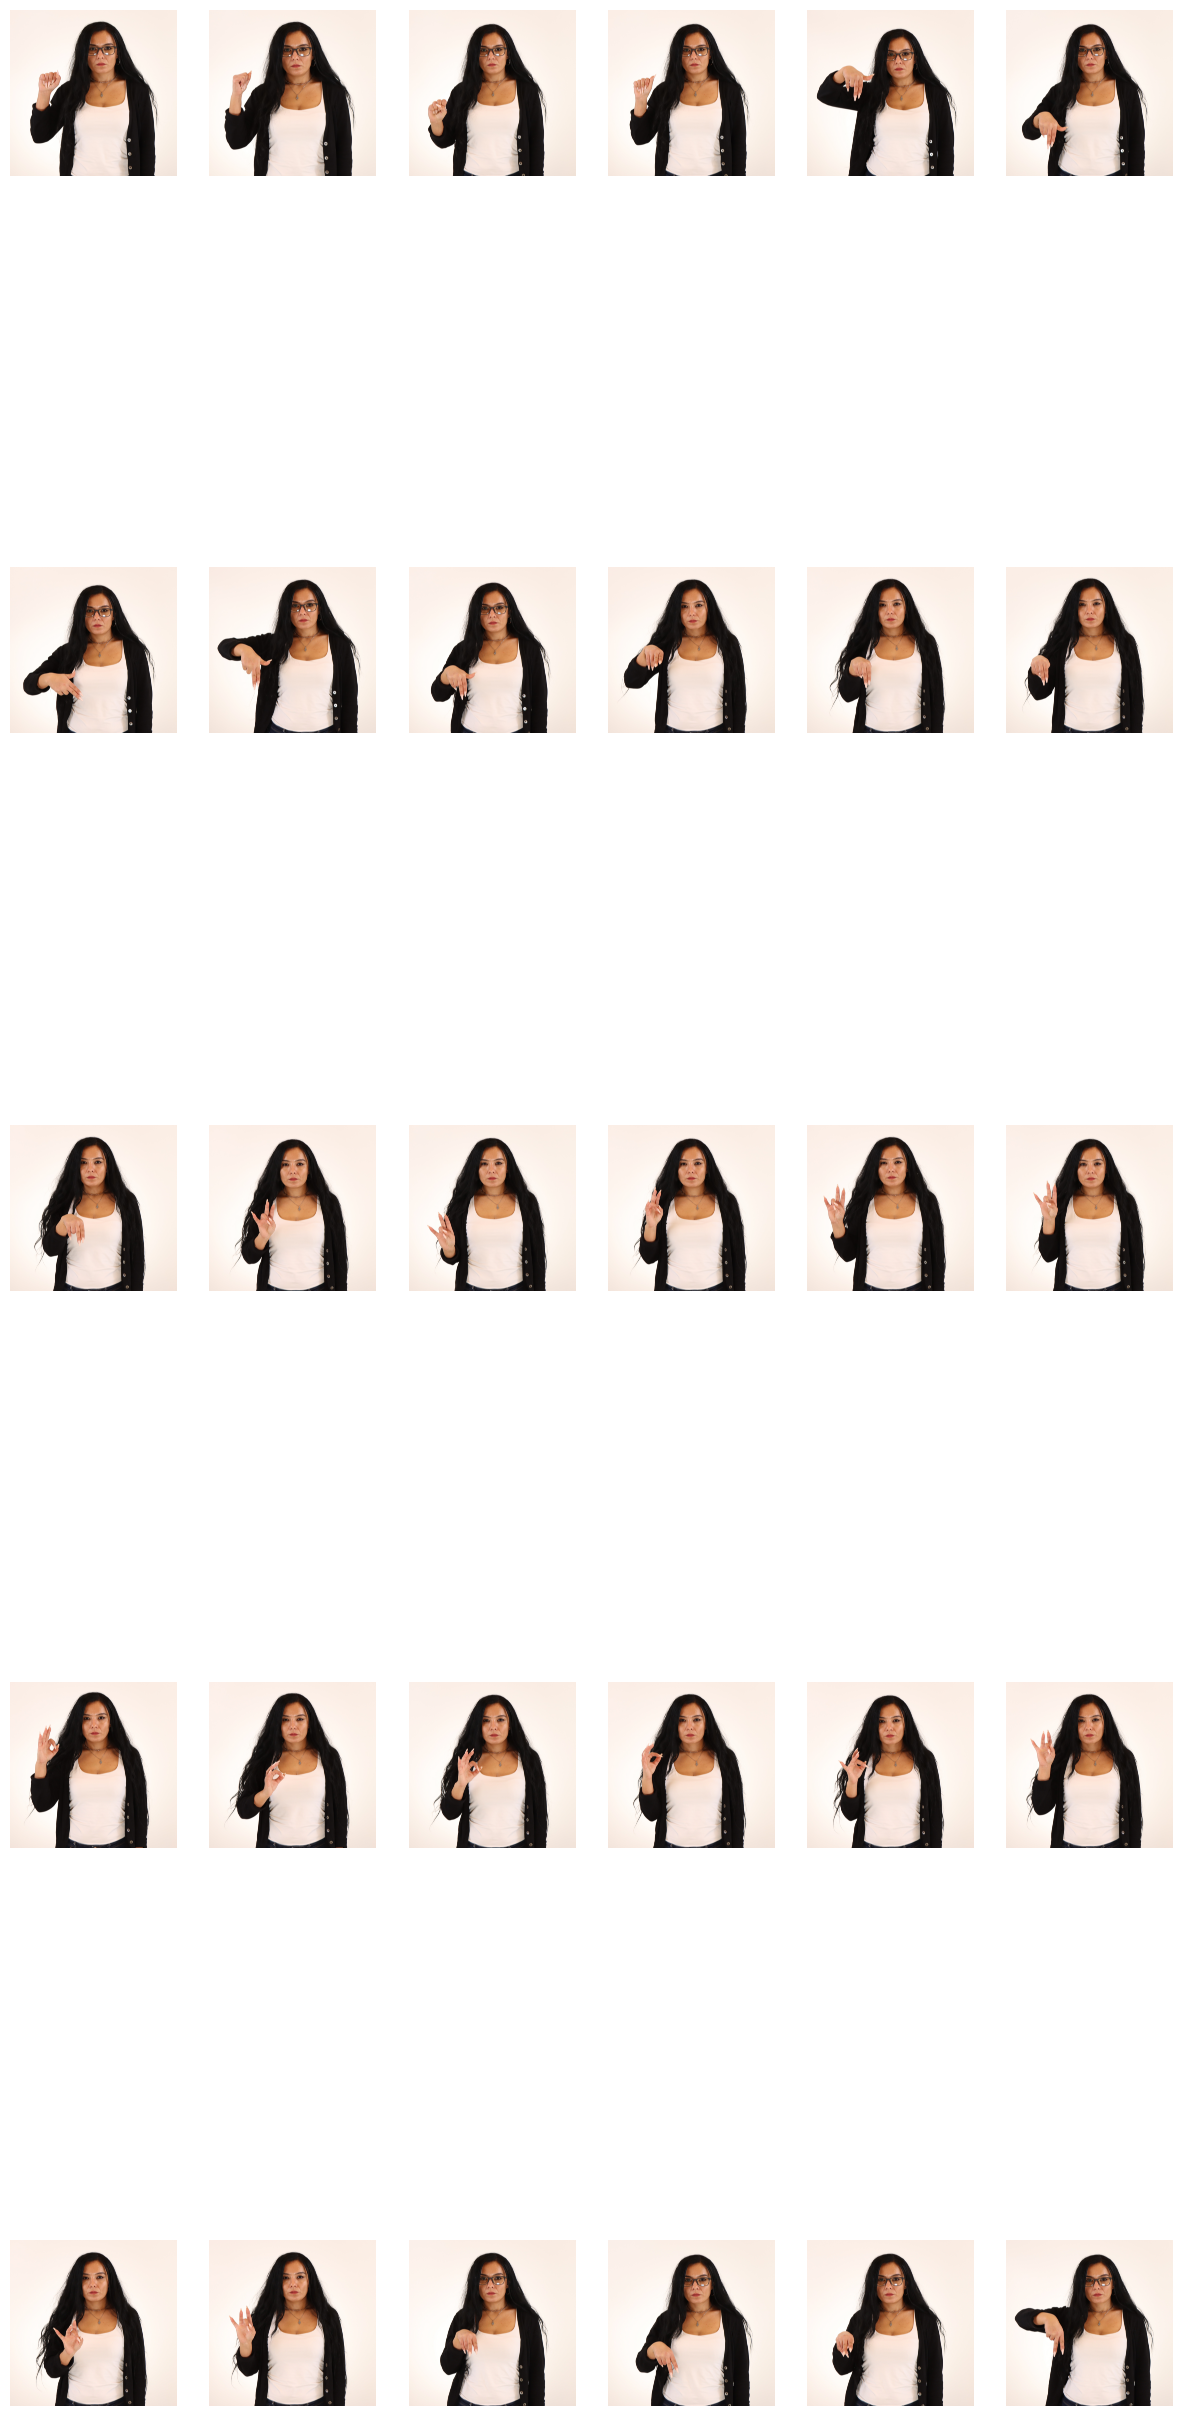

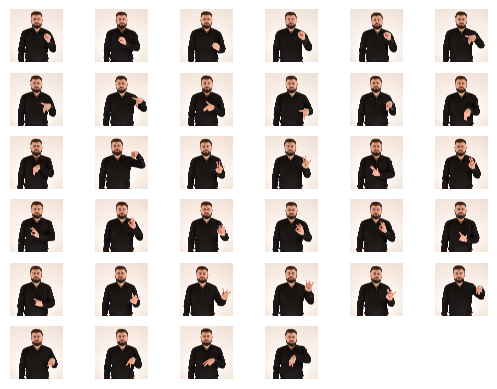

In [ ]:
visualize_clusters(tsne_embedding, conf.imgs[conf.img_type], clusters)

In [ ]:
get_cluster_info(clusters, conf.img_paths["sign"])

Cluster 1: 
Letter Counts: {'A': 4, 'H': 5, 'P': 4, 'N': 5, 'O': 4, 'R': 4, 'L': 4}
Total Count: 30

Cluster 2: 
Letter Counts: {'A': 5, 'H': 5, 'P': 4, 'N': 4, 'O': 5, 'R': 6, 'L': 5}
Total Count: 34

Cluster 3: 
Letter Counts: {'A': 6, 'H': 5, 'P': 6, 'N': 5, 'O': 7, 'R': 7, 'L': 5}
Total Count: 41

Cluster 4: 
Letter Counts: {'A': 5, 'H': 4, 'P': 4, 'N': 4, 'O': 4, 'R': 4, 'L': 5}
Total Count: 30

Cluster 5: 
Letter Counts: {'A': 3, 'H': 2, 'P': 3, 'N': 2, 'O': 2, 'R': 5, 'L': 3}
Total Count: 20

Cluster 6: 
Letter Counts: {'A': 6, 'H': 5, 'P': 5, 'N': 5, 'O': 4, 'R': 5, 'L': 5}
Total Count: 35

Cluster 7: 
Letter Counts: {'A': 3, 'H': 3, 'P': 2, 'N': 3, 'O': 3, 'R': 1, 'L': 2}
Total Count: 17

